# Analysis of Ar39 simulations by CJ
In this notebook, we aim to analyse the simulations of 1e6 Ar39 decays.
Since this is a preliminary study, we will structure the analysis as:
- Analysis of energy spectrum, in particular energy deposited in Ar39 and energy detected.
- Analysis of time, aiming to highlight when occur the higher energy depositions.
- Analsysi of space to see the localization of energy deposition with respect to the original starting point of decay.


In [2]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})

In [3]:
# Load Ar39 data
dir_in = os.path.join("..", "Data", "ar39")
filename = "all_ar39.csv"

df = pd.read_csv(os.path.join(dir_in, filename), index_col=False)
df.head()    # Show preview

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID
0,11,1,199.602808,0.0,10965981533621045248,145.475123,-41.761746,876.506390,0.329759,0.138789,0.933808,0,4,eIoni,1000180390
1,1000190390,1,0.007450,0.0,10965981533621045248,145.475123,-41.761746,876.506390,-0.003431,-0.453118,-0.891444,0,2,ionIoni,1000190390
2,11,1,127.671402,0.0,7978349220669757440,305.754361,32.901259,-35.512578,0.149663,-0.759912,0.632562,1,4,eIoni,1000180390
3,1000190390,1,0.007276,0.0,7978349220669757440,305.754361,32.901259,-35.512578,-0.528607,0.798146,-0.289028,1,2,ionIoni,1000190390
4,11,1,22.204675,0.0,12169737727684888576,309.174425,112.813957,48.999119,0.097874,0.828458,-0.551433,3,4,eIoni,1000180390


**Note**: CJ root files contains `2185641` entries, our csv exportation only `2185013`. The reason is that CJ simulates primaries in ROI but collect all the entries of secondaries in LAr volume. Then, during the preprocessing, we cut off all entries not in ROI, explaining the small data reduction.

## Analsysis of energy

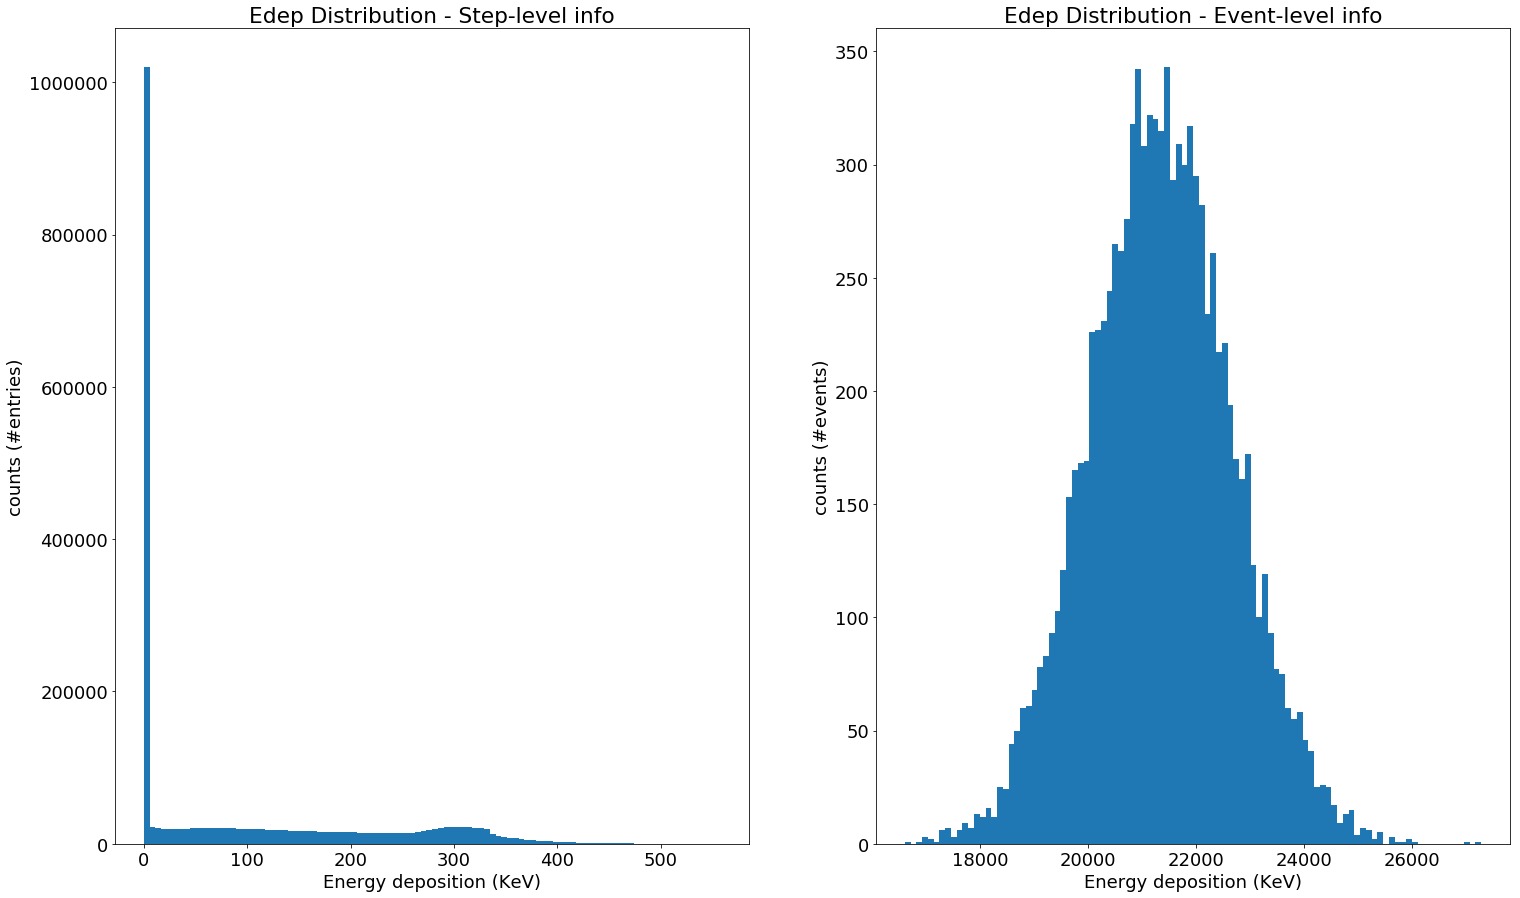

In [7]:
edep_stats = df.energydeposition.describe()

plt.subplot(1, 2, 1)
plt.hist(df.energydeposition, bins=100)
plt.title("Edep Distribution - Step-level info")
plt.xlabel("Energy deposition (KeV)")
plt.ylabel("counts (#entries)")

plt.subplot(1, 2, 2)
plt.hist(df.groupby("eventnumber").energydeposition.sum(), bins=100)
plt.title("Edep Distribution - Event-level info")
plt.xlabel("Energy deposition (KeV)")
plt.ylabel("counts (#events)")

plt.show()

# Analysis of time

In [4]:
df.time = df.time.astype("float")
df = df.sort_values("time")

In [5]:
pd.DataFrame([df.time.describe(), 
              df.energydeposition.describe(),
              df.groupby("eventnumber").energydeposition.sum().describe()], 
             index=["Time(steplevel)", "Edep(steplevel)", "CumEdep(eventlevel)"])

,count,mean,std,min,25%,50%,75%,max
Time(steplevel),2185013.0,1.223367e+19,1.225231e+19,2.490492e+12,3.514346e+18,8.463270e+18,1.694953e+19,1.585198e+20
Edep(steplevel),2185013.0,9.765940e+01,1.219257e+02,8.003553e-08,6.314272e-03,2.534614e+01,1.878591e+02,5.578690e+02
CumEdep(eventlevel),10000.0,2.133870e+04,1.323126e+03,1.660470e+04,2.044840e+04,2.133021e+04,2.221825e+04,2.727629e+04


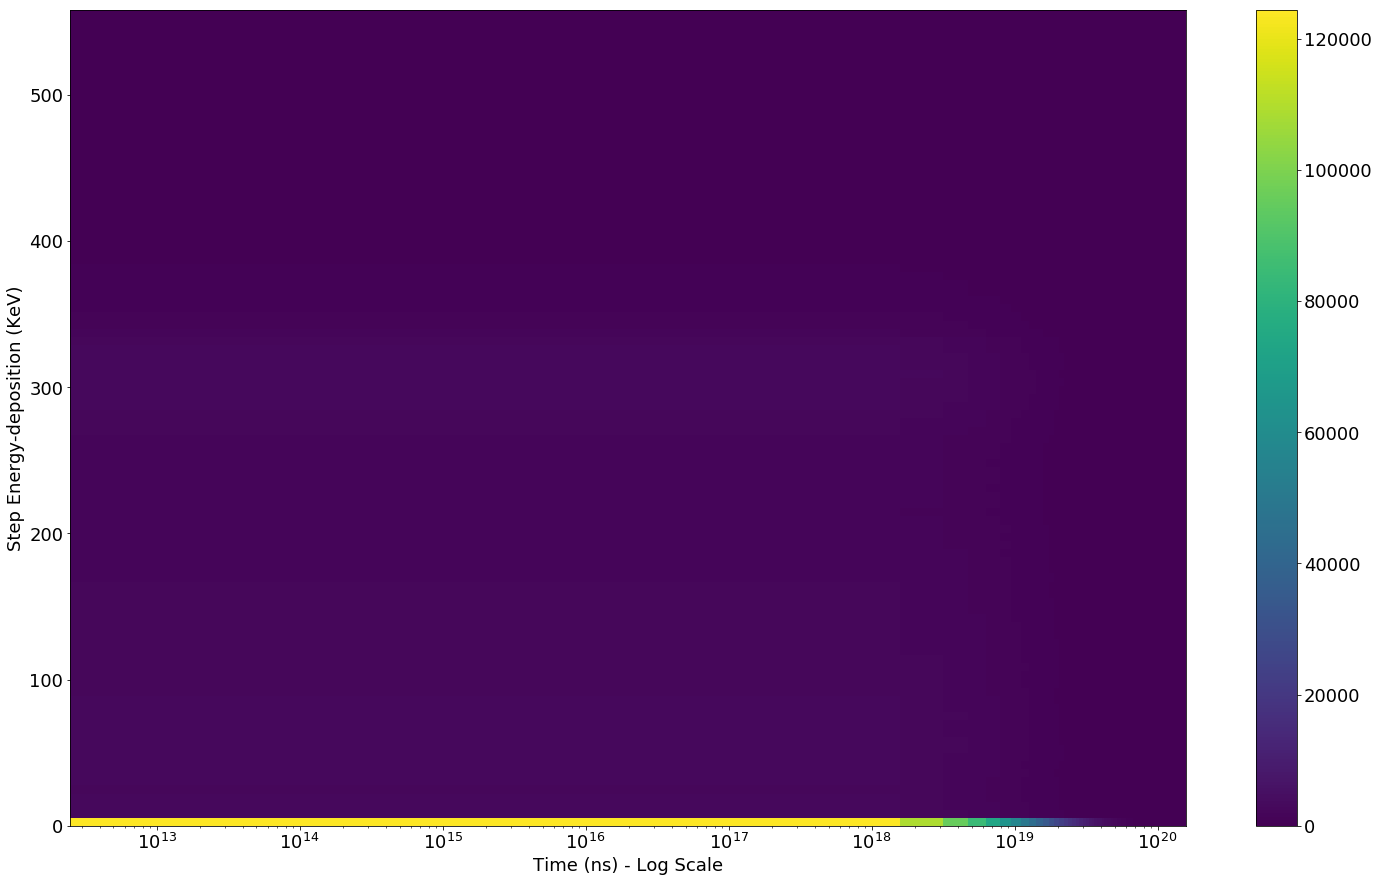

In [47]:
time_bins = np.logspace(12, 21, 100)
plt.hist2d(df.time, df.energydeposition, bins=[100, 100])
plt.colorbar()
plt.xscale("log")
plt.xlabel("Time (ns) - Log Scale")
plt.ylabel("Step Energy-deposition (KeV)")
plt.show()

In [11]:
first_edep_xevent = df.groupby("eventnumber").time.first()

In [20]:
time = np.zeros(len(df))
import time as t
begin = t.time()
for i, (idx, row) in enumerate(df.iterrows()):
    if i%100000==0:
        print("Row {} - {} sec".format(i, t.time()-begin))
    time[i] = row.time - first_edep_xevent.loc[row.eventnumber]
time

Row 0 - 1.206336259841919 sec
Row 100000 - 18.263253927230835 sec
Row 200000 - 34.51765823364258 sec
Row 300000 - 49.74561381340027 sec
Row 400000 - 64.41392755508423 sec
Row 500000 - 79.51889085769653 sec
Row 600000 - 94.51401782035828 sec
Row 700000 - 109.55279588699341 sec
Row 800000 - 124.5605399608612 sec
Row 900000 - 140.37473464012146 sec
Row 1000000 - 155.39199781417847 sec
Row 1100000 - 170.29280376434326 sec
Row 1200000 - 185.3359136581421 sec
Row 1300000 - 200.90477395057678 sec
Row 1400000 - 215.95008969306946 sec
Row 1500000 - 231.5259611606598 sec
Row 1600000 - 246.62441873550415 sec
Row 1700000 - 261.78871178627014 sec
Row 1800000 - 277.2939808368683 sec
Row 1900000 - 292.77618169784546 sec
Row 2000000 - 307.86866307258606 sec
Row 2100000 - 323.6115047931671 sec


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.53999817e+20, 1.58517433e+20, 1.58517433e+20])

In [21]:
df['time_net'] = time.tolist()
df.head()

,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID,time_net
1831458,11,1,331.310504,0.0,2.490492e+12,192.364572,-145.774623,-218.762336,-0.322923,-0.304791,-0.896004,8064,4,eIoni,1000180390,0.000000
1831459,1000190390,1,0.009828,0.0,2.490492e+12,192.364572,-145.774623,-218.762336,0.384465,0.109226,0.916655,8064,2,ionIoni,1000190390,0.000000
487377,11,1,70.324083,0.0,5.821026e+12,-207.382445,394.517073,796.755997,0.859559,-0.119416,0.496888,2947,4,eIoni,1000180390,0.000000
487378,1000190390,1,0.004032,0.0,5.821026e+12,-207.382445,394.517073,796.755997,-0.771194,-0.515805,0.373103,2947,2,ionIoni,1000190390,0.000977
1523844,11,1,198.792590,0.0,1.983894e+13,-38.038719,171.610113,563.068261,0.113810,0.506562,-0.854659,7151,4,eIoni,1000180390,0.000000


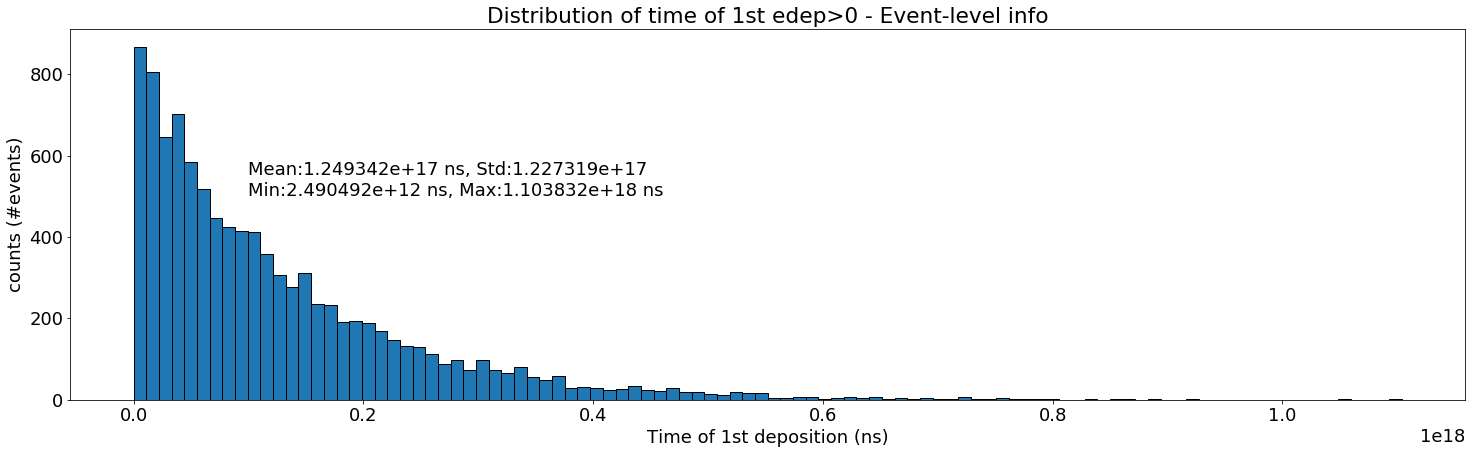

AttributeError: 'DataFrame' object has no attribute 'time_net'

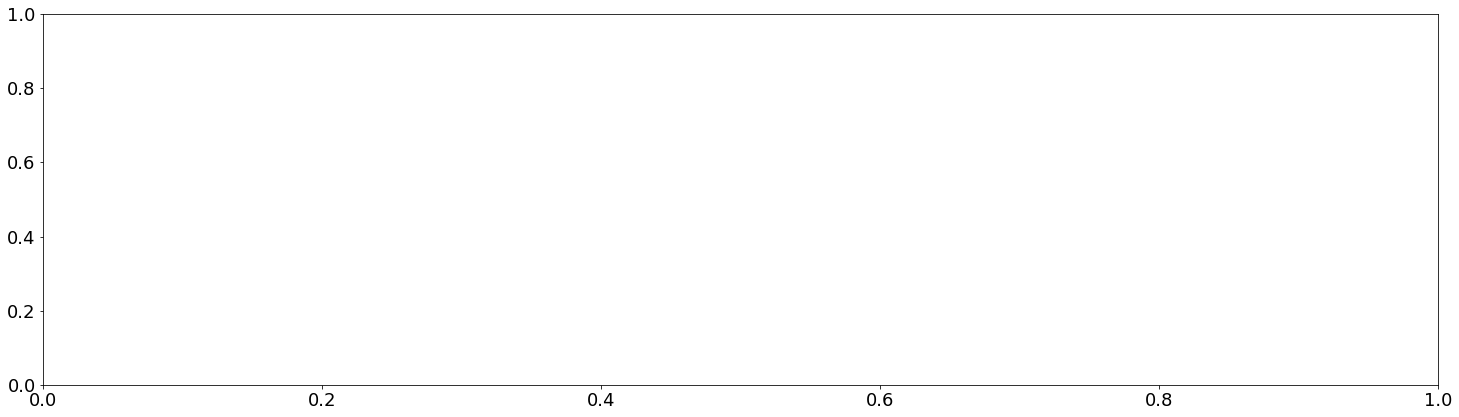

In [54]:
stat_1_edep = first_edep_xevent.describe()
plt.subplot(2, 1, 1)
plt.hist(first_edep_xevent, bins=100, edgecolor="k")
#plt.xscale("log")
plt.title("Distribution of time of 1st edep>0 - Event-level info")
plt.xlabel("Time of 1st deposition (ns)")
plt.ylabel("counts (#events)")
plt.text(10**17, 500, "Mean:{:e} ns, Std:{:e}\n" \
                      "Min:{:e} ns, Max:{:e} ns".format(stat_1_edep.loc["mean"], 
                                                    stat_1_edep.loc["std"],
                                                    stat_1_edep.loc["min"],
                                                    stat_1_edep.loc["max"]))
plt.show()

plt.subplot(2, 1, 2)
plt.hist(df.time_net, bins=time_bins)
plt.xscale("log")
plt.title("Distribution of (time - (1stedep time)) - Step-level info")
plt.xlabel("Time of deposition w.r.t. event's 1st edep (ns)")
plt.ylabel("counts (#entries)")
plt.show()


In [22]:
pd.DataFrame([df.time.describe(), df.time_net.describe()], index=["Time(step)", "Time Net(step)"])

,count,mean,std,min,25%,50%,75%,max
Time(step),2185013.0,1.223367e+19,1.225231e+19,2.490492e+12,3.514346e+18,8.463270e+18,1.694953e+19,1.585198e+20
Time Net(step),2185013.0,1.210878e+19,1.225181e+19,0.000000e+00,3.387814e+18,8.337891e+18,1.682618e+19,1.585174e+20


In [39]:
lst_describes = []
indices = []
nevents_in_interval = []
for i in range(1, 100+1):
    base = 10**19
    begin, end = (i-1)*base, i*base
    if i==0:
        nevents_in_interval.append(df[df.time<end].eventnumber.nunique())
        lst_describes.append(df[df.time<10**ex].energydeposition.describe())
        indices.append("Time<{:e}".format(end))
    else:
        nevents_in_interval.append(df[(df.time>=begin) & (df.time<end)].eventnumber.nunique())
        lst_describes.append(df[(df.time>=begin) & (df.time<end)].energydeposition.describe())
        indices.append("{:e}<=Time<{:e}".format(begin, end))
time_parts = pd.DataFrame(lst_describes, index=indices)
time_parts = time_parts.rename(columns={"count": "#entries"})
time_parts.insert(1, "#events", nevents_in_interval)
time_parts

,#entries,#events,mean,std,min,25%,50%,75%,max
0.000000e+00<=Time<1.000000e+19,1220538.0,10000,97.643429,121.906781,8.003553e-08,0.006310,25.371259,187.867434,557.868952
1.000000e+19<=Time<2.000000e+19,538287.0,10000,97.766549,122.048397,1.120497e-06,0.006317,25.385231,188.107223,552.872557
2.000000e+19<=Time<3.000000e+19,237966.0,10000,97.475833,121.746829,9.895302e-07,0.006331,25.007610,187.384234,554.671782
3.000000e+19<=Time<4.000000e+19,105030.0,9918,97.806582,121.859105,1.091394e-06,0.006314,25.534970,187.981442,549.785811
4.000000e+19<=Time<5.000000e+19,46199.0,8701,97.599160,121.905253,1.010631e-05,0.006300,25.649653,187.950833,538.461607
5.000000e+19<=Time<6.000000e+19,20526.0,6007,97.370071,121.983447,1.047010e-05,0.006336,25.791704,186.117315,524.396816
6.000000e+19<=Time<7.000000e+19,9208.0,3377,97.651467,122.631787,2.951128e-05,0.006384,23.854699,187.631016,524.713074
7.000000e+19<=Time<8.000000e+19,4033.0,1660,98.928600,123.001126,1.418884e-04,0.006204,24.682226,193.463523,508.398118
8.000000e+19<=Time<9.000000e+19,1802.0,780,97.007565,121.915368,6.362825e-05,0.006473,24.580426,190.545190,472.343579
9.000000e+19<=Time<1.000000e+20,799.0,350,92.977350,119.121831,1.091394e-04,0.006324,18.137299,171.491346,433.494569


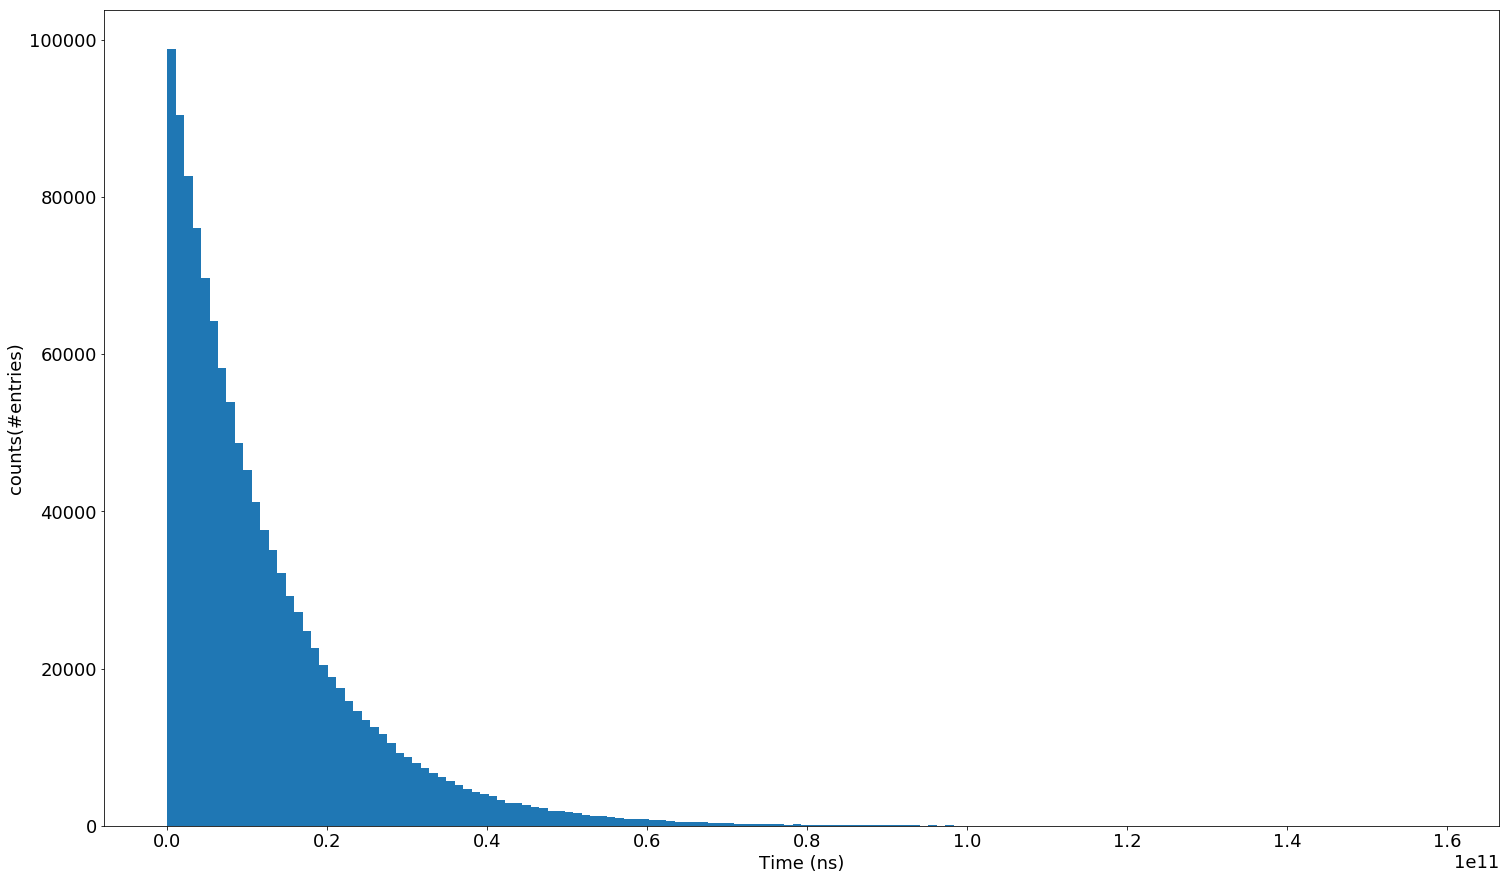

In [20]:
betas = df[df.PID==11]
plt.hist(betas.time*10**-9, bins=150)
plt.xlabel("Time (ns)")
plt.ylabel("counts(#entries)")
plt.show()

In [27]:
df.eventnumber.describe()

count    2.185013e+06
mean     4.999974e+03
std      2.886379e+03
min      0.000000e+00
25%      2.499000e+03
50%      5.001000e+03
75%      7.500000e+03
max      9.999000e+03
Name: eventnumber, dtype: float64

In [48]:
first_edep_xevent.describe()

count    1.000000e+04
mean     1.249342e+17
std      1.227319e+17
min      2.490492e+12
25%      3.614157e+16
50%      8.847734e+16
75%      1.742636e+17
max      1.103832e+18
Name: time, dtype: float64

In [9]:
event8064 = df[df.eventnumber==8064]
event8064[event8064.PID==1000190390]


,PID,ParentTrackID,energydeposition,kineticenergy,time,x,y,z,px,py,pz,eventnumber,tracknumber,creatorprocess,parentnucleusPID
1831459,1000190390,1,0.009828,0.0,2.490492e+12,192.364572,-145.774623,-218.762336,0.384465,0.109226,0.916655,8064,2,ionIoni,1000190390
345399,1000190390,1,0.006060,0.0,1.253377e+16,-44.160152,-180.616042,-456.471710,-0.374243,0.095322,0.922419,8064,2,ionIoni,1000190390
1197845,1000190390,1,0.011172,0.0,3.143756e+16,99.956707,448.305682,-674.300650,-0.128757,-0.586387,-0.799732,8064,2,ionIoni,1000190390
1853400,1000190390,1,0.004743,0.0,3.577675e+16,-165.635754,354.644842,742.465377,0.308392,-0.663993,0.681181,8064,2,ionIoni,1000190390
170255,1000190390,1,0.004640,0.0,3.180995e+17,493.404575,-61.015968,-44.481782,0.446381,0.484051,-0.752621,8064,2,ionIoni,1000190390
1591424,1000190390,1,0.011358,0.0,4.763475e+17,61.939050,371.313847,820.501391,0.796541,-0.580051,0.170480,8064,2,ionIoni,1000190390
279679,1000190390,1,0.008685,0.0,1.299935e+18,-165.424306,-228.663287,-618.757274,-0.750454,0.652632,0.104360,8064,2,ionIoni,1000190390
2027869,1000190390,1,0.002841,0.0,1.570011e+18,-261.245057,29.860772,-784.909187,-0.145467,-0.240720,-0.959632,8064,2,ionIoni,1000190390
1482058,1000190390,1,0.010274,0.0,1.579010e+18,383.157547,309.446499,908.415273,0.095702,0.396102,0.913205,8064,2,ionIoni,1000190390
389172,1000190390,1,0.004217,0.0,1.633747e+18,-144.998813,77.669825,813.520152,0.449606,0.413369,-0.791821,8064,2,ionIoni,1000190390


In [10]:
space_ar39 = df[df.PID==1000190390][["x", "y", "z"]]

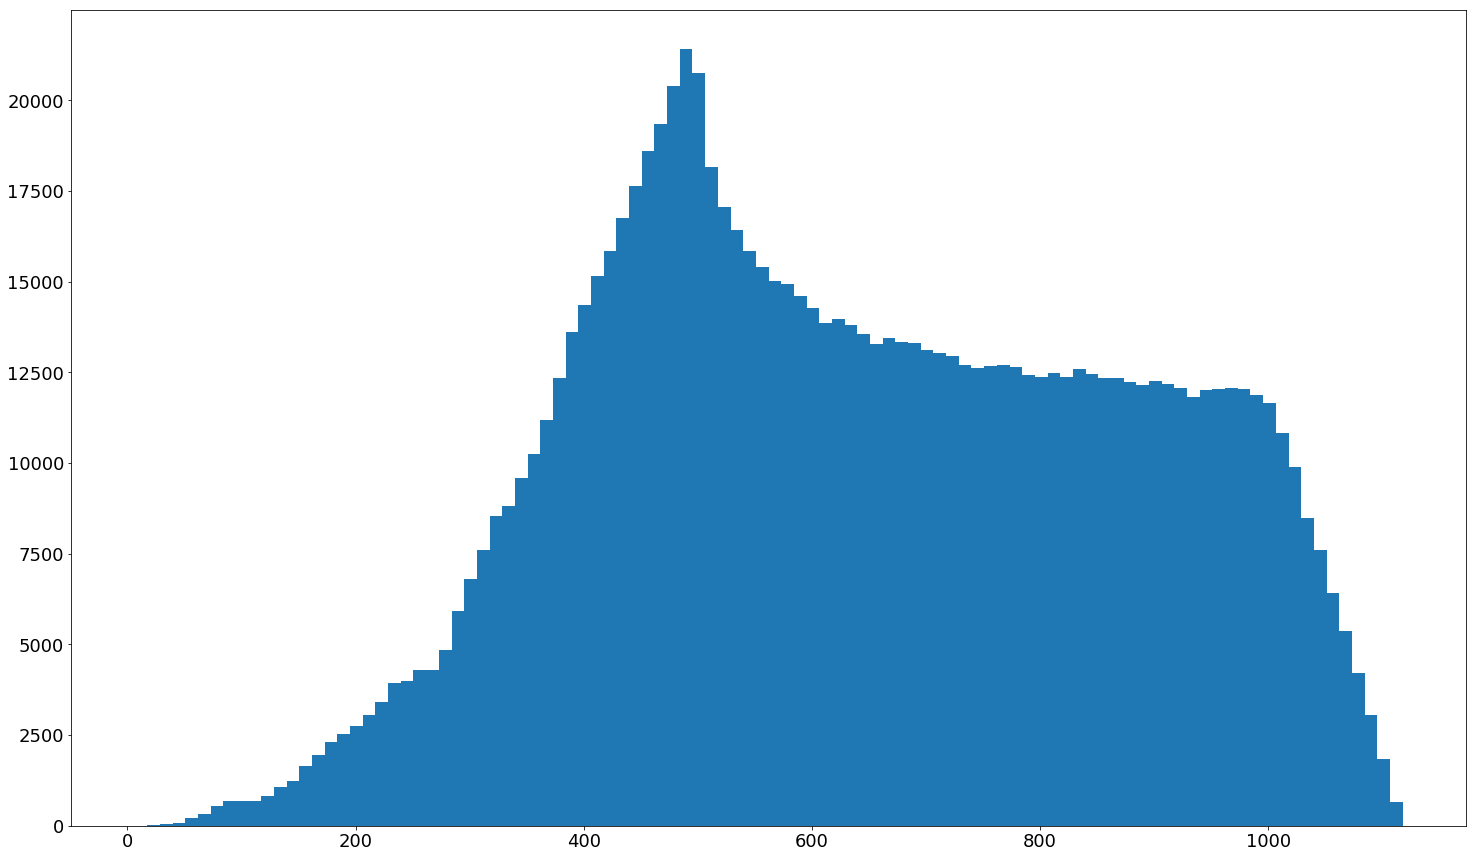

In [16]:
plt.hist((space_ar39.x**2 + space_ar39.y**2 + space_ar39.z**2)**.5, bins=100)
plt.show()

# Merge Ar39 simulations based on activity
CJ provides us individual Ar39 simulations, we will merge them according to the measured activity in liquid argon and the volume size.

In particular, we know from Mario Schwarz calculations:
- The instrumented volume is `2.6` m^3
- The measured activity of Ar39 in liquid argon is `1.41` Bq/l
- `1` m^3 of liquid argon corresponds to `1000` liters

Then, the number of Ar39 decays that we expect in one second is
`1.41 * 2.6 * 1000 = 3666`

From Giuseppe's note:
- Number of Ar39 per liter: `17.6*10^9` particle/liter
Then, the number of particles of Ar39 in 2.6m^3 is
`17.6*10^9 * 2600 = 45.76 * 10^12`. A lot!


In [18]:
df["sec"] = df.time / 1000000000

In [24]:
coords_gbevent = df.groupby("eventnumber")[["x", "y", "z"]]

In [28]:
min_coords_perevent = coords_gbevent.min()
max_coords_perevent = coords_gbevent.max()

min_coords_perevent.head()


,x,y,z
eventnumber,,,
0,-457.211474,-475.159514,-986.304718
1,-484.871523,-491.423743,-997.984863
2,-438.108208,-496.149038,-969.057199
3,-449.217111,-474.285277,-993.053327
4,-474.488105,-466.523243,-992.241939


Each event will spread over the whole argon volume, it is not localized. In fact, each event has minimum x, y, z as lower limit of the coordinate, and maximum x, y, z as upper limit.

Then, we cannot find interesting pattern in localization of data, because 